# Assignment 4
## Econ 8310 - Business Forecasting

This assignment will make use of the bayesian statistical models covered in Lessons 10 to 12.

A/B Testing is a critical concept in data science, and for many companies one of the most relevant applications of data-driven decision-making. In order to improve product offerings, marketing campaigns, user interfaces, and many other user-facing interactions, scientists and engineers create experiments to determine the efficacy of proposed changes. Users are then randomly assigned to either the treatment or control group, and their behavior is recorded.
If the changes that the treatment group is exposed to can be measured to have a benefit in the metric of interest, then those changes are scaled up and rolled out to across all interactions.
Below is a short video detailing the A/B Testing process, in case you want to learn a bit more:
[https://youtu.be/DUNk4GPZ9bw](https://youtu.be/DUNk4GPZ9bw)

For this assignment, you will use an A/B test data set, which was pulled from the Kaggle website (https://www.kaggle.com/datasets/yufengsui/mobile-games-ab-testing). I have added the data from the page into Codio for you. It can be found in the cookie_cats.csv file in the file tree. It can also be found at [https://github.com/dustywhite7/Econ8310/raw/master/AssignmentData/cookie_cats.csv](https://github.com/dustywhite7/Econ8310/raw/master/AssignmentData/cookie_cats.csv)

The variables are defined as follows:

| Variable Name  | Definition |
|----------------|----|
| userid         | A unique number that identifies each player  |
| version        | Whether the player was put in the control group (gate_30 - a gate at level 30) or the group with the moved gate (gate_40 - a gate at level 40) |
| sum_gamerounds | The number of game rounds played by the player during the first 14 days after install.  |
| retention1     | Did the player come back and play 1 day after installing?     |
| retention7     | Did the player come back and play 7 days after installing?    |               

### The questions

You will be asked to answer the following questions in a small quiz on Canvas:
1. What was the effect of moving the gate from level 30 to level 40 on 1-day retention rates?
2. What was the effect of moving the gate from level 30 to level 40 on 7-day retention rates?
3. What was the biggest challenge for you in completing this assignment?

You will also be asked to submit a URL to your forked GitHub repository containing your code used to answer these questions.

   userid  version  sum_gamerounds  retention_1  retention_7
0     116  gate_30               3        False        False
1     337  gate_30              38         True        False
2     377  gate_40             165         True        False
3     483  gate_40               1        False        False
4     488  gate_40             179         True         True

Summary statistics:
              userid  version  sum_gamerounds retention_1 retention_7
count   9.018900e+04    90189    90189.000000       90189       90189
unique           NaN        2             NaN           2           2
top              NaN  gate_40             NaN       False       False
freq             NaN    45489             NaN       50036       73408
mean    4.998412e+06      NaN       51.872457         NaN         NaN
std     2.883286e+06      NaN      195.050858         NaN         NaN
min     1.160000e+02      NaN        0.000000         NaN         NaN
25%     2.512230e+06      NaN        5.000000        

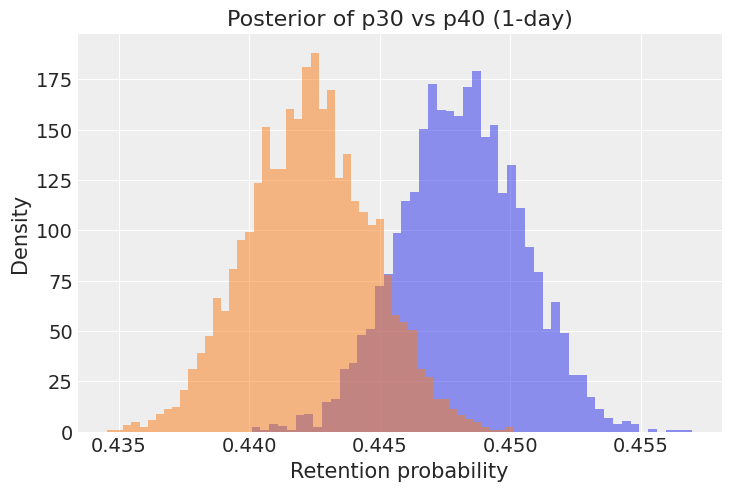

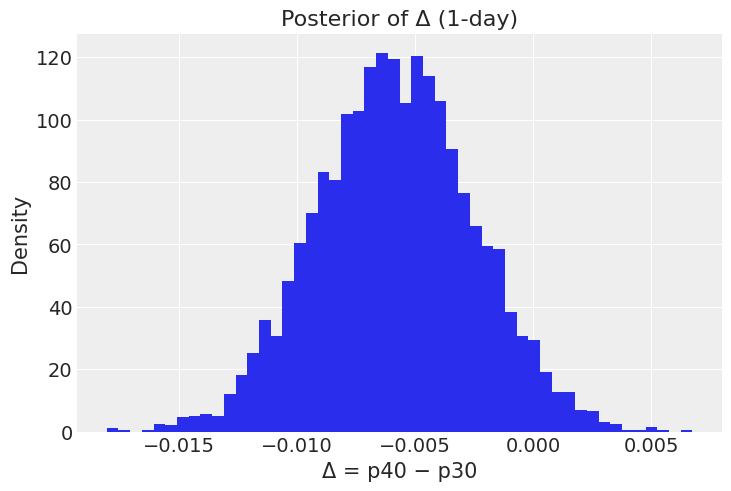

Day-7 retention Δ (gate40 − gate30): -0.816%
95% CI: [-1.323%, -0.307%]



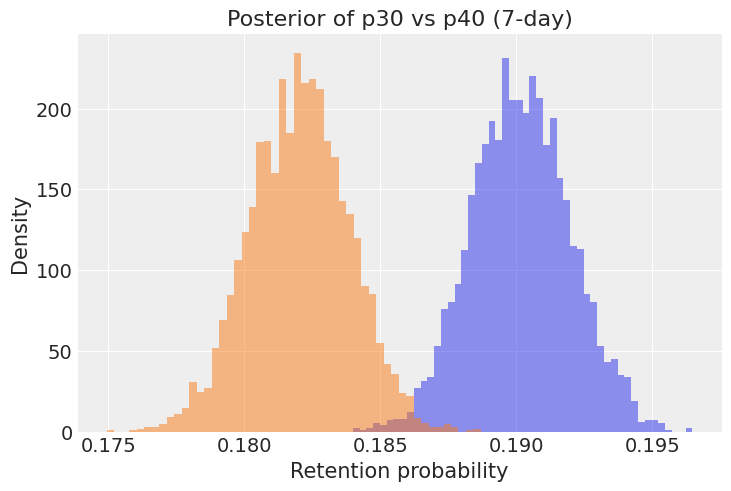

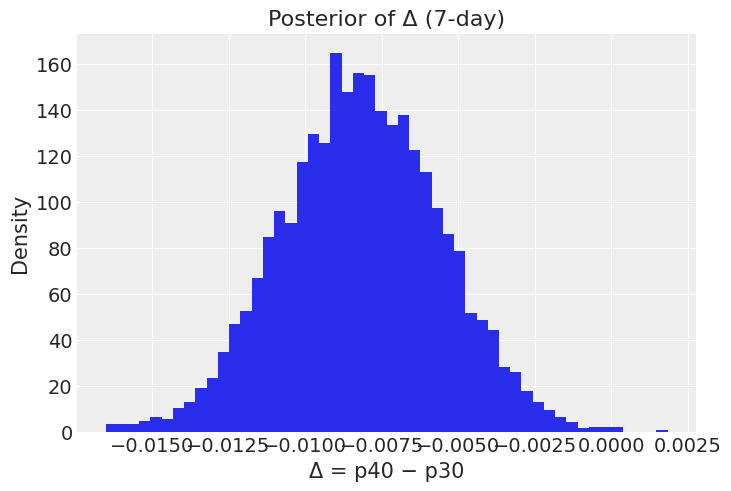

In [32]:
import pandas as pd
import numpy as np
import pymc as pm
import matplotlib.pyplot as plt

url = "https://raw.githubusercontent.com/dustywhite7/Econ8310/master/AssignmentData/cookie_cats.csv"
df = pd.read_csv(url)
print(df.head())
print("\nSummary statistics:")
print(df.describe(include='all'))


df['retention_1'] = df['retention_1'].astype(int)
df['retention_7'] = df['retention_7'].astype(int)

###### MODEL FOR 1-DAY RETENTION
with pm.Model() as model_day1:
    # Priors for each gate
    p30_1 = pm.Uniform('p30_1', 0, 1)
    p40_1 = pm.Uniform('p40_1', 0, 1)
    # Deterministic difference
    delta_1 = pm.Deterministic('delta_1', p40_1 - p30_1)
    # Likelihoods
    obs30_1 = pm.Bernoulli('obs30_1', p30_1,
                           observed=df.query("version=='gate_30'")['retention_1'])
    obs40_1 = pm.Bernoulli('obs40_1', p40_1,
                           observed=df.query("version=='gate_40'")['retention_1'])
    # Sampling
    trace_1 = pm.sample(2000, tune=1000, chains=2, random_seed=42, progressbar=False)

# Extract posterior draws
posterior_1 = trace_1.posterior.stack(draws=("chain","draw"))
p30_samps_1 = posterior_1.p30_1.values
p40_samps_1 = posterior_1.p40_1.values
delta_samps_1 = posterior_1.delta_1.values

# Summaries for Day-1
mean_delta1 = delta_samps_1.mean()
ci_delta1 = np.percentile(delta_samps_1, [2.5, 97.5])

print(f"Day-1 retention Δ (gate40 − gate30): {mean_delta1:.3%}")
print(f"95% CI: [{ci_delta1[0]:.3%}, {ci_delta1[1]:.3%}]\n")

# Plot posterior p30 vs p40 (Day-1)
plt.figure()
plt.hist(p30_samps_1, bins=50, density=True, alpha=0.5)
plt.hist(p40_samps_1, bins=50, density=True, alpha=0.5)
plt.xlabel("Retention probability")
plt.ylabel("Density")
plt.title("Posterior of p30 vs p40 (1-day)")
plt.show()

# Plot posterior Δ (Day-1)
plt.figure()
plt.hist(delta_samps_1, bins=50, density=True)

plt.xlabel("Δ = p40 − p30")
plt.ylabel("Density")
plt.title("Posterior of Δ (1-day)")
plt.show()

#### MODEL FOR 7-DAY RETENTION
with pm.Model() as model_day7:
    p30_7 = pm.Uniform('p30_7', 0, 1)
    p40_7 = pm.Uniform('p40_7', 0, 1)
    delta_7 = pm.Deterministic('delta_7', p40_7 - p30_7)
    obs30_7 = pm.Bernoulli('obs30_7', p30_7,
                           observed=df.query("version=='gate_30'")['retention_7'])
    obs40_7 = pm.Bernoulli('obs40_7', p40_7,
                           observed=df.query("version=='gate_40'")['retention_7'])
    trace_7 = pm.sample(2000, tune=1000, chains=2, random_seed=42, progressbar=False)

# Extract posterior draws
posterior_7 = trace_7.posterior.stack(draws=("chain","draw"))
p30_samps_7 = posterior_7.p30_7.values
p40_samps_7 = posterior_7.p40_7.values
delta_samps_7 = posterior_7.delta_7.values

# Summaries for Day-7
mean_delta7 = delta_samps_7.mean()
ci_delta7 = np.percentile(delta_samps_7, [2.5, 97.5])

print(f"Day-7 retention Δ (gate40 − gate30): {mean_delta7:.3%}")
print(f"95% CI: [{ci_delta7[0]:.3%}, {ci_delta7[1]:.3%}]\n")

# Plot posterior p30 vs p40 (Day-7)
plt.figure()
plt.hist(p30_samps_7, bins=50, density=True, alpha=0.5)
plt.hist(p40_samps_7, bins=50, density=True, alpha=0.5)
plt.xlabel("Retention probability")
plt.ylabel("Density")
plt.title("Posterior of p30 vs p40 (7-day)")
plt.show()

# Plot posterior Δ (Day-7)
plt.figure()
plt.hist(delta_samps_7, bins=50, density=True)
plt.xlabel("Δ = p40 − p30")
plt.ylabel("Density")
plt.title("Posterior of Δ (7-day)")
plt.show()
